# Qafar-af Speech Command Recognition: Recognizing keywords

This Notebook demonstrates the preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing five different words in Qafar-af Language. The dataset is collected and processed which contains short (one-second or less) audio clips of commands, such as "Qembis", "Derreh", "Gurra", "Migda", "Solis", "Noise" and "unknown".

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Mubarekethio">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    GitHub Link</a>
  </td>
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  
  <td>
    <a href="https://drive.google.com/file/d/1kSgqk6snZ2mA1j_PAjpw02wNIZhvm27G/view?usp=sharing"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

Import necessary modules and dependencies. 
#.mu.env_310

In [3]:
#pip install -U -q tensorflow tensorflow_datasets
#pip install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import librosa

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tensorflow import lite
from tensorflow.keras import models
import time

from timeit import default_timer as timer

#from tensorflow import keras

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

start = timer()
end = timer()
print(f'Execution Time:{end-start}')

Execution Time:1.6900012269616127e-05


## Import Qafaraf speech Commands dataset

I have use `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. For visualization in [seaborn](https://seaborn.pydata.org) is used.

In [4]:
#The dataset's audio clips are stored in seven folders corresponding to each speech command: `Qembis`, `Derreh`, `Migda`, `Gurra`, `Solis`, `A_noise` and `unknown`:
data_dir_tr =  '../_V_Data/Af_data_V/data-V-af-Splitted/Train_MM/' #splitted_QF/Train_MM/'
data_dir_ts= "../_V_Data/Af_data_V/data-V-af-Splitted/Test_MM/"#'../_V_Data/splitted_QF/Test_MM/'
data_dir_vl="../_V_Data/Af_data_V/data-V-af-Splitted/Val_MM/" #'../_V_Data/splitted_QF/Val_MM/'

commands = np.array(tf.io.gfile.listdir(str(data_dir_tr)))
#commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['A_noise' 'Derreh' 'Gurra' 'Migda' 'Qembis' 'Solis' 'Unknown']


Divided the dataset into train, test and Validation dataset. `keras.utils.audio_dataset_from_directory` is used to load and convert the audiodataset in a batch of tensorflow format, and it provide some parameter to split test and train data the number of the batch number and output sequence length to trim large audio file in equal length of data1.
1. The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.
2. But i have used different folder of data for train, test and validation dataset then i upload it directtly from folder 

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use 
`Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

#test_ds = val_ds.shard(num_shards=2, index=0)
#val_ds = val_ds.shard(num_shards=2, index=1)

In [5]:
#train dataset
train_ds= tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir_tr,
    batch_size=64,
    seed=0,
    output_sequence_length=16000)
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)
#test dataset
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir_ts,
    batch_size=64,
    seed=0,
    output_sequence_length=16000,)
label_names_ts = np.array(test_ds.class_names)
print()
print("label names:", label_names_ts)

#Validation dataset
val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir_vl,
    batch_size=64,
    seed=0,
    output_sequence_length=16000,)

label_names_vl = np.array(val_ds.class_names)
#print()
print("label names:", label_names_vl)


Found 3132 files belonging to 7 classes.

label names: ['A_noise' 'Derreh' 'Gurra' 'Migda' 'Qembis' 'Solis' 'Unknown']
Found 899 files belonging to 7 classes.

label names: ['A_noise' 'Derreh' 'Gurra' 'Migda' 'Qembis' 'Solis' 'Unknown']
Found 476 files belonging to 7 classes.
label names: ['A_noise' 'Derreh' 'Gurra' 'Migda' 'Qembis' 'Solis' 'Unknown']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [6]:
print(train_ds.element_spec)
print(test_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [7]:
def squeeze(audio, labels):
    audio=tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

Let's plot a few audio waveforms:

In [8]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_audio.shape)

label_names[[0,1,2,3,4,5,6]]

labels_list = label_names.tolist()
labels_list

(64, 16000)
(64, 16000)


['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']

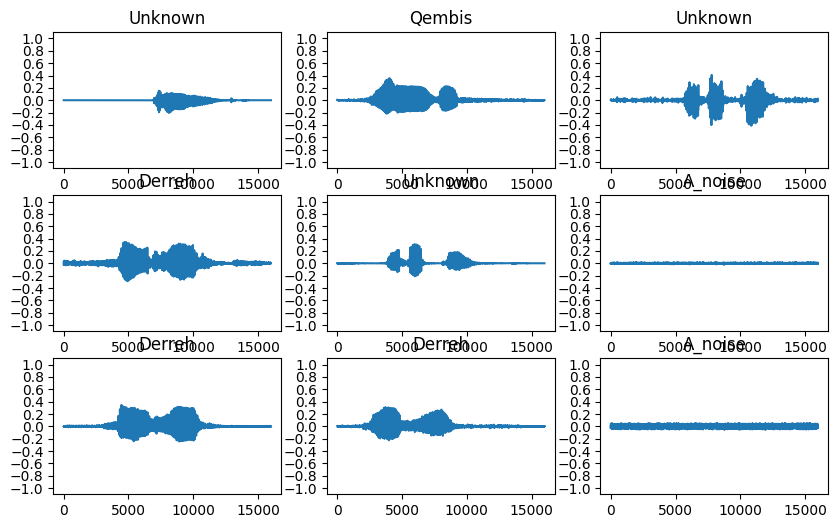

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i in range(n):
    if i>=n:
        break
    r= i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

## Feature Extraction using Spectrograms

Converting the waveform to spectrogram feature. The waveforms in the dataset are represented in the time domain. Next, transform this waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. Then the spectrogram images is feed into neural network model to train the model.
A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that run standard convolutions on it.
Here's a breakdown of what the function does:

1. STFT Calculation: It computes the Short-Time Fourier Transform (STFT) of the waveform using tf.signal.stft. The frame_length specifies the length of the window for each frame, and frame_step indicates the number of samples between successive frames.

2. Magnitude Calculation: It takes the absolute value of the STFT result to obtain the magnitude, which represents the intensity of different frequencies over time.

3. Dimension Adjustment: It adds a channels dimension to the spectrogram. This dimension is added to mimic image-like data, making it compatible with convolutional neural networks (CNNs) that expect input data in the shape (batch_size, height, width, channels).

In [35]:
def get_spectrogram(waveform):
  #convert to mono
  #waveform= convert_to_mono(wav)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=256) #fft_length=1024) #255 128
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  #spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### Create Spectrogram Datasets
Now, by using #get_spectrogram function create spectrogram datasets for training test and validation dataset.:

In [36]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

### Exploring Spectrogram Dataset In random audio
Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:


In [37]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: Unknown
Waveform shape: (16000,)
Spectrogram shape: (61, 257)
Audio playback


Label: Qembis
Waveform shape: (16000,)
Spectrogram shape: (61, 257)
Audio playback


Label: Unknown
Waveform shape: (16000,)
Spectrogram shape: (61, 257)
Audio playback


Now, define a function for  plot and displaying a spectrogram of an audio data:

In [38]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

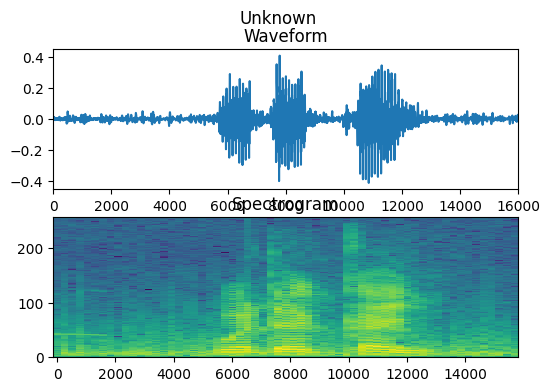

In [39]:
fig, axes = plt.subplots(2, figsize=(6, 4))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

### Plot Spectrogram in random dataset

In [40]:
#get example mfcc feature dataset from train mfcc dataset and number of class
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(2):
  break

inSpec_shape = example_spectrograms.shape[1:]
print('Input shape:', inSpec_shape)
num_labels = len(label_names)
inSpec_shape

Input shape: (61, 257)


TensorShape([61, 257])

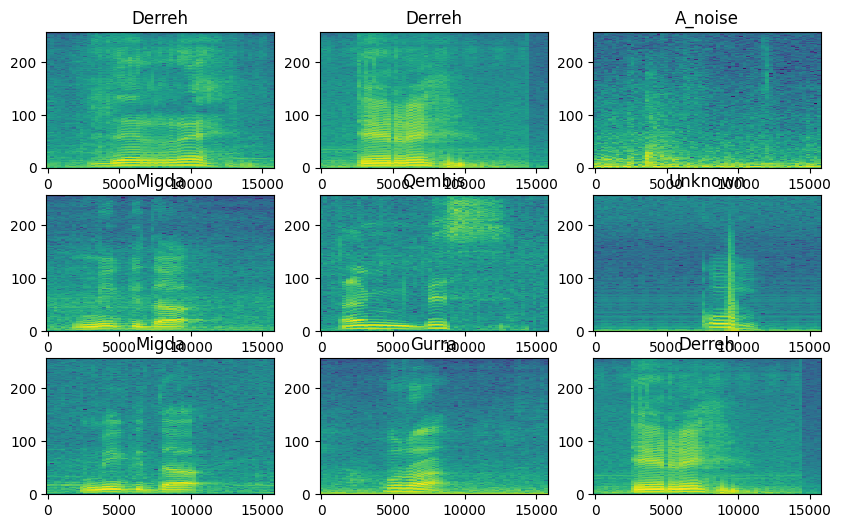

In [41]:

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()




#### Add Caching and Prefetching Datasets
Caching and Prefetching Datasets using Dataset.cache() and Dataset.prefetch(): The train_spectrogram_ds, val_spectrogram_ds, and test_spectrogram_ds datasets are processed with caching and prefetching to enhance training performance and to reduce read latency while training the model.

In [42]:
#Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Feature Extraction using (MFCCs)


MFCC are commonly used in speech and audio processing to represent the spectral characteristics of a signal. To convert waveforms to MFCCs, the steps are as follows: Steps to Convert Waveforms to MFCCs:
1. Preprocessing:
a. Pre-emphasis: Apply a high-pass filter to emphasize higher frequencies.
b. Frame the Signal: Divide the signal into frames of fixed duration (e.g., 20-30 milliseconds).
c. Windowing: Apply a window function (like Hamming, Hanning) to each frame to reduce spectral leakage.

2. Fast Fourier Transform (FFT):
a. Compute the Power Spectrum: Convert each frame from the time domain to the frequency domain using FFT.

3. Mel Filterbank:
a. Apply Mel Filterbank: Convert the power spectrum to the mel scale using a filterbank of triangular filters.

4. Logarithm:
a. Take the Logarithm: Calculate the logarithm of the powers obtained from the filterbank.

5. Discrete Cosine Transform (DCT):
a. Apply DCT: Transform the logarithm of filterbank energies to the cepstral domain.

6. Extract Coefficients:
a. Keep Relevant Coefficients: Typically, only a subset of resulting coefficients is kept (usually the lower-frequency ones) to reduce dimensionality and discard noise.

### Build a Function to do MFCC Feature Extraction

"apply_mfccs" is function  that takes an audio signal as input and computes its Mel-frequency cepstral coefficients (MFCCs) using TensorFlow functions for signal processing. This function involves a series of signal processing steps to extract MFCCs from the audio signal. Let's break down what the function does:

1. Short-Time Fourier Transform (STFT): Decomposes the audio signal into its frequency components over short, overlapping time windows using tf.signal.stft.
2. Compute Spectrograms: Calculates the magnitude of the STFT to obtain spectrograms.
3. Mel Transformation: Converts the spectrograms into Mel-scaled spectrograms using tf.signal.linear_to_mel_weight_matrix.
4. Log Transformation: Computes the logarithm of the Mel-scaled spectrograms to enhance the scale for MFCC computation.
5. MFCC Computation: Computes MFCCs from the log Mel-scaled spectrograms using tf.signal.mfccs_from_log_mel_spectrograms.
6. Reshaping: Reshapes the computed MFCCs and returns them.

The function apply_mfccs takes an audio signal tensor as input and returns the computed MFCCs after performing these signal processing steps.

In [47]:
#You can use this function by passing an audio signal tensor as input:
def apply_mfccs(audio_signal, sample_rate=16000, num_mfccs=13):
    # Short-Time Fourier Transform (STFT)
    stfts = tf.signal.stft(audio_signal, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)

    # Mel Transformation
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Log Transformation
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 2e-6)

    # Compute MFCCs from log Mel-scaled spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]

    #mfccs = mfccs[..., tf.newaxis]
    return mfccs

### Exploring AudioData in MFCC
Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding MFCC, and play the original audio:

In [48]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    mfccs = apply_mfccs(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('MFCC shape:', mfccs.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: Unknown
Waveform shape: (16000,)
MFCC shape: (59, 13)
Audio playback


Label: Qembis
Waveform shape: (16000,)
MFCC shape: (59, 13)
Audio playback


Label: Unknown
Waveform shape: (16000,)
MFCC shape: (59, 13)
Audio playback


To plot the MFCCs for audio samples extracted from different classes, libraries like Matplotlib to visualize the MFCCs can be used. Here's an example of plot the MFCCs for each class using TensorFlow to extract the MFCC features:
  The plotting settings can be modified, such as the number of samples plotted per class or the figure size, as needed for your visualization.

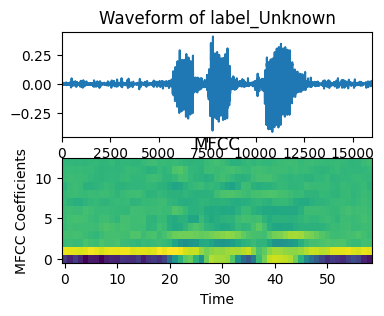

In [49]:
fig, axes = plt.subplots(2, figsize=(4, 3))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title(f'Waveform of label_{label}')
axes[0].set_xlim([0, 16000])


mfccs_to_plot = np.squeeze(mfccs.numpy())  # Remove the last axis if it's 1
axes[1].imshow(mfccs_to_plot.T, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title('MFCC')

plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
#axes[1].title('MFCCs Visualization')
plt.show()

### Create MFCC Datasets
Now, create MFCC datasets from the audio datasets:

In [50]:
def make_mfcc_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (apply_mfccs(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)


train_mfcc_ds = make_mfcc_ds(train_ds)
val_mfcc_ds = make_mfcc_ds(val_ds)
test_mfcc_ds = make_mfcc_ds(test_ds)

### Examine and Explore MFCC Dataset

In [51]:
#get example mfcc feature dataset from train mfcc dataset and number of class
for example_mfcc, example_mfcc_labels in train_mfcc_ds.take(2):
    break


inMfcc_shape = example_mfcc.shape[1:]
print('Input shape:', inMfcc_shape)
num_labels = len(label_names)
print('number of label:', label_names)


Input shape: (59, 13)
number of label: ['A_noise' 'Derreh' 'Gurra' 'Migda' 'Qembis' 'Solis' 'Unknown']


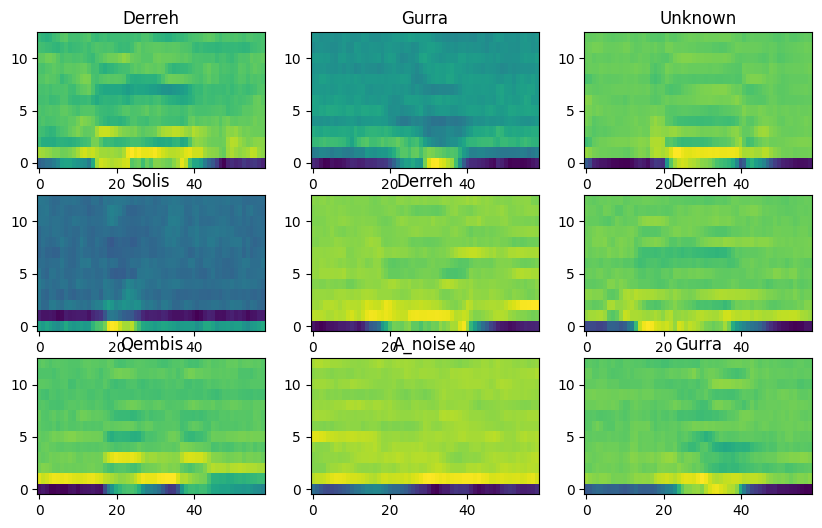

In [52]:
#show some of the example mfcc feature dataset 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    # Reshape MFCCs for plotting (if needed)
    mfccs_to_plot = np.squeeze(example_mfcc[i].numpy())  # Remove the last axis if it's 1
    ax.imshow(mfccs_to_plot.T, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title(label_names[example_mfcc_labels[i].numpy()])


plt.show()

#### Add Caching and Prefetching Datasets
Caching and Prefetching Datasets using Dataset.cache() and Dataset.prefetch(): The train_ft_ds, val_ft_ds, and test_ft_ds datasets are processed with caching and prefetching to enhance training performance and to reduce read latency while training the model.

In [53]:
#Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:
train_mfcc_ds = train_mfcc_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds = val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_ds = test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)

## Build and Train RNN Model


This RNN model comprises:
1. Sequential Model: Similar to the CNN, it's a sequence of layers.
2. Input Layer: Defines the input shape.
3. LSTM Layers: Long Short-Term Memory layers for sequential data processing. They capture sequential information effectively.
4. Dense Layers: Fully connected layers for classification.
5. Model Summary: Provides an overview of the model's architecture.
6. Compilation: Configures the model for training with Adam optimizer and sparse categorical cross-entropy loss, monitoring accuracy as a metric.

Both the CNN and RNN models are designed for different types of data. The CNN is suitable for grid-like data (images), while the RNN is suitable for sequential data (text, time series). The provided RNN mimics the structure of the CNN but is tailored for sequential data processing using LSTM layers. Adjustments can be made based on the specific requirements of your task and the characteristics of your data.

In [43]:
#from tensorflow.keras import layers, models

def apply_RNN(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
    ])

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

### Define a function to Plot Training Validation loss curve

The  `plot_training` function designed to visualizing the training history of a neural network model. It takes the history object returned by the model.fit() function in TensorFlow, which contains information about the training and validation metrics (e.g., loss, accuracy) for each epoch. Here's a breakdown of what the function does:

1. Extract Metrics: It extracts the training and validation metrics from the history object.
2. Plotting Loss Curve: Plots the training and validation loss against the number of epochs.
3. Plotting Accuracy Curve: Plots the training and validation accuracy against the number of epochs.

In [25]:
def plot_training(history):
    metrics = history.history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], label='Training Loss')
    plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='Training Accuracy')

    plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

### Define Function to Evaluate the model performance and to Draw Confusion Matrix

The `Eval_conf` function designed to evaluate the performance of a model using a test dataset (tst_ft_ds). It prints out the accuracy and loss of the model and draws a confusion matrix to visualize the model's performance. Here's a breakdown of the function:
1. Evaluate Model: Uses the model.evaluate() function to evaluate the model's performance on the test dataset (tst_ft_ds).and Prints out the accuracy and loss of the model on the test dataset.
1. [Confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix):
   - Obtains the model's predictions on the test dataset using model.predict().
   - Converts the predicted and true labels into a suitable format (y_pred, y_true).
   - Constructs a confusion matrix using TensorFlow's tf.math.confusion_matrix() function.
   - Plots the confusion matrix using sns.heatmap() from the Seaborn library.

In [26]:
def Eval_conf(tst_ft_ds, model, label_names):
    print('.....Evaluate the model......')
    eval_results = model.evaluate(tst_ft_ds)
    accuracy = eval_results[1]
    loss = eval_results[0]

    print(f'Accuracy in (%):- {accuracy * 100}')
    print(f'Loss:- {loss}')

    print('.....Draw the confusion matrix of the model......')
    y_pred = model.predict(tst_ft_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat([lab for _, lab in tst_ft_ds], axis=0)

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')

    plt.xlabel('Prediction')
    plt.title("Confusion Matrix")
    plt.ylabel('Label')

    plt.show()

### Define a function to Save the trained model and To Convert the model in `tflite` Format

The `model_save` function designed to save a trained model using two methods of TensorFlow's models.
1. The .h5 keras tensoflow model format 
   - it is used by Keras to save the architecture, weights, optimizer state, and any other necessary information to recreate a Keras model. It's a convenient way to store the entire model for later use, transfer between different machines, or deploy to production.
2. TensorFlow's saved_model format 
   - it provides a way to save and load models that is independent of the high-level API (like Keras). It's a more flexible format that can store a TensorFlow model's computation graph, variables, and assets separately, allowing for easier integration with other tools and serving platforms.

The `model_save_tflite` function designed to converting a Keras model to a TensorFlow Lite (TFLite) model.
- A TFLite (TensorFlow Lite) model is a special version of a TensorFlow model optimized for deployment on mobile and edge devices. It's designed to be more lightweight and efficient, enabling faster inference on devices with limited computational resources like smartphones, IoT devices, and embedded systems.

In [80]:
def model_save(model, model_filename):
    tf.saved_model.save(model, model_filename)
    #models.save_model(model, model_filename)

def model_save_tflite(keras_model, tflite_filename):
    converter = lite.TFLiteConverter.from_keras_model(keras_model)
    #converter = tf.lite.TFLiteConverter.from_saved_model(keras_model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()

    #tflite_model = converter.convert()
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

### Define a function to Run inference on an audio file

Before inference the audio file `read_audio_tf` is used to Reading Audio File: using TensorFlow's tf.io.read_file and decodes it using tf.audio.decode_wav. and Displays the audio using display.Audio.

In [27]:
def read_audio_tf(aud_f):
    x = tf.io.read_file(str(aud_f))
    tf_x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    tf_x = tf.squeeze(tf_x, axis=-1)
    print(".......The original Audio.............")
    display.display(display.Audio(tf_x, rate=16000))
    return tf_x

Plot the predicted Bar

In [28]:
def plot_pred_bar(all_targets, pred):
    plt.bar(all_targets, pred)
    p_label= np.argmax(pred)
    #print(f'the prediction value of all class:{pred}')
    print(f'Predicted label is:{all_targets[p_label]}')
    print(f'Inference Time:{end-start}')
    plt.title(all_targets[p_label])
    plt.show()

To verify the model's prediction output using an input audio file. The `run_inference` function is designed to perform inference using a saved model (model_c) on an audio file (aud_f) and display the prediction probabilities along with the predicted label Here's a breakdown of the function:
1. Reading Audio: using `read_audio_tf` function 
1. Feature Extraction: Depending on the value of spectrogram_used, extracts either spectrogram or MFCC features from the audio file.
1. Model Inference:
   - Passes the extracted features to the provided model (model_c) for prediction.
   - Performs softmax on the prediction and displays the probabilities using a bar plot.
   - Prints the predicted label and inference time.

In [63]:
#Run inference using saved_model
def run_inference(aud_f, model_c, x_labels, spectrogram_used):
    start = timer()

    ## Read the audio file and convert the audio in to tensoflow object
    tf_x= read_audio_tf(aud_f)

    ##Get the feature from the waveform audio either either in MFCC or spectrogram
    if(spectrogram_used):
        ft_x = get_spectrogram(tf_x)
        ft_x = ft_x[tf.newaxis,...]
        print('.....Using Spectrogram Feature........')
    else:
        ft_x= apply_mfccs(tf_x)
        ft_x = ft_x[tf.newaxis,...]
        print('.....Using MFCC Feature........')

    ##Get prediction from the model by giving the feature of the audio data
    prediction = model_c(ft_x)
    end = timer()
    pred= tf.nn.softmax(prediction[0])

    plot_pred_bar(x_labels, pred)



### Define a function to run inference using tflite file


This function, `run_inference_tflite`, is intended to perform inference using a TensorFlow Lite (TFLite) interpreter on an audio file (aud_f). It extracts either spectrogram or MFCC features from the audio, feeds them to the TFLite model, and displays the prediction probabilities along with the predicted label. Here's a breakdown of the function:
1. Reading Audio File: using `read_audio_tf` function 
2. Feature Extraction:
   - Depending on the value of spectrogram_used, extracts either spectrogram or MFCC features from the audio file. 
3. Model Inference with TFLite Interpreter:
   - Sets the input tensor to the TFLite model with the extracted features.
   - Invokes the TFLite interpreter to perform inference.
   - Retrieves the output tensor from the interpreter, which contains the model's predictions.
4. Post-processing and Visualization:
   - Processes the output data to obtain the predicted label and its corresponding probability.
   - Prints the predicted label, inference time, and displays a bar plot of the prediction probabilities.

In [97]:
def run_inference_tflite(aud_f, model_path, all_targets, spectrogram_used):
    ## Read the audio file and convert the audio in to tensoflow object
    tf_x= read_audio_tf(aud_f)
    ##Get the feature from the waveform audio either either in MFCC or spectrogram
    if(spectrogram_used):
        spec = get_spectrogram(tf_x)
        spec = spec[tf.newaxis,...]
    else:
        spec= apply_mfccs(tf_x)
        spec = spec[tf.newaxis,...]

    print(spec.shape)
    start= timer()

    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # Make prediction from model
    interpreter.set_tensor(input_details[0]['index'], spec)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    end = timer()
    pred= tf.nn.softmax(output_data[0])#, axis= 1)

    plot_pred_bar(all_targets, pred)

## Train and Evaluate the Model For Spectrogram feature

By using  `apply_RNN` function obtain the model (model_spec). This function appears to handle the creation of a Recurrental neural network (CNN) model and preprocessing of the datasets.

In [45]:
#import numpy as np

# Assuming your data is named 'X_train'
# Reshape the data for sequence processing
#X_train_reshaped = np.squeeze(X_train, axis=-1)  # Removing the last axis if it's not necessary

#train_spectrogram_ds= np.squeeze(train_spectrogram_ds, axis=-1)

# Now the shape should be (batch_size, timesteps, features)
# For instance, if 'X_train' has a shape of (samples, 61, 257, 1)
# Reshape it to (samples, 61, 257)

model_spec =apply_RNN(inSpec_shape,
                    num_labels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 61, 128)           197632    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 256,263
Trainable params: 256,263
Non-trainable params: 0
_________________________________________________________________


The code snippet train a model (model_spec) using training and validation data (train_spec_ds and val_spec_ds) for a certain number of epochs (EPOCHS). It also includes an EarlyStopping callback to monitor the validation loss and stop training if it doesn't improve after a certain number of epochs (patience=2 in this case).

In [46]:
#train the model using train and val data and Epoch
EPOCHS = 10

history_spec = model_spec.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

Epoch 1/10


49/49 [==============================] - 17s 162ms/step - loss: 1.2766 - accuracy: 0.5166 - val_loss: 0.6636 - val_accuracy: 0.7437
Epoch 2/10
49/49 [==============================] - 8s 155ms/step - loss: 0.4904 - accuracy: 0.8126 - val_loss: 0.3636 - val_accuracy: 0.9118
Epoch 3/10
49/49 [==============================] - 9s 175ms/step - loss: 0.3424 - accuracy: 0.9039 - val_loss: 0.4029 - val_accuracy: 0.8697
Epoch 4/10
49/49 [==============================] - 8s 167ms/step - loss: 0.2110 - accuracy: 0.9527 - val_loss: 0.2404 - val_accuracy: 0.9328
Epoch 5/10
49/49 [==============================] - 8s 165ms/step - loss: 0.1855 - accuracy: 0.9543 - val_loss: 0.2247 - val_accuracy: 0.9412
Epoch 6/10
49/49 [==============================] - 8s 166ms/step - loss: 0.1315 - accuracy: 0.9706 - val_loss: 0.1393 - val_accuracy: 0.9601
Epoch 7/10
49/49 [==============================] - 8s 170ms/step - loss: 0.1043 - accuracy: 0.9757 - val_loss: 0.1247 - val_accuracy: 0.9685
Epoch 8/10
49/49

To plot the training and validation loss curve using a function named `plot_training` by passing in the history_spec object, likely the training history of the model model_spec.

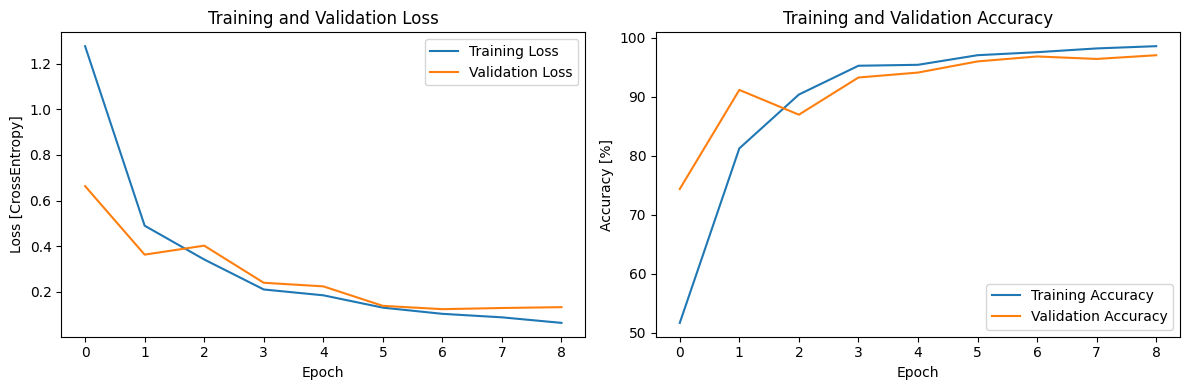

In [54]:
#Plot the training validation loss curve
plot_training(history_spec)

Evaluate the model's performance on the test dataset (tst_ft_ds) and visualize the confusion matrix using a function called `Eval_conf`. Additionally, defined label_names as a list of labels from the class of the data

.....Evaluate the model......
15/15 [==============================] - 3s 86ms/step - loss: 0.0706 - accuracy: 0.9844
Accuracy in (%):- 98.44271540641785
Loss:- 0.07058018445968628
.....Draw the confusion matrix of the model......
15/15 [==============================] - 1s 42ms/step


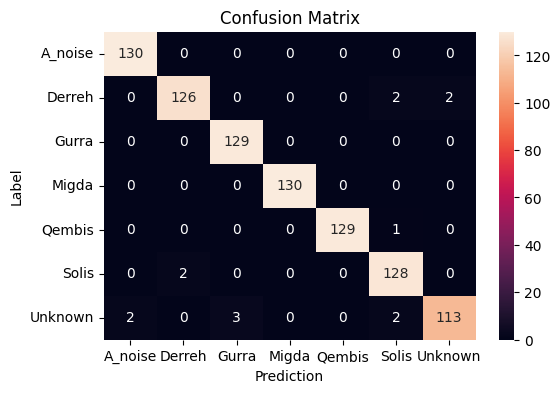

In [55]:
#Evaluate the model performance and see the confusion matrix
#label_list=['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']

Eval_conf(test_spectrogram_ds, model_spec, labels_list)

By loading an audio file (Afar-afe_test4.wav) running inference on this audio using a model trained (model_spec). The goal is to be extract features from the audio and displaying the predicted audio using a bar plot along with the original audio.
The function `run_inference` is handle this task, extracting either spectrogram or MFCC features based on the parameter spectrogram_used True for spectrogram and False for MFCC.

.......The original Audio.............


.....Using Spectrogram Feature........
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


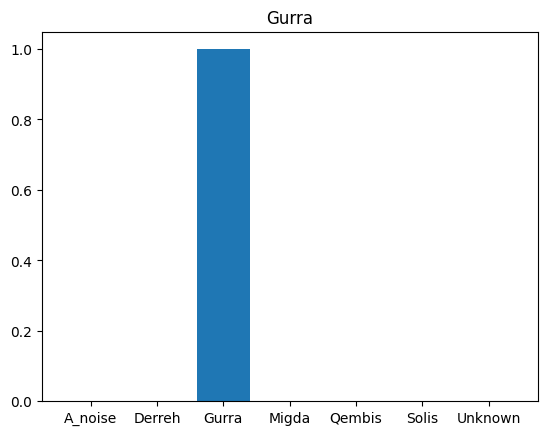

In [64]:
#Load an audio and convert to tensorflow
x= '../_V_Data/Qf_For_test/Afar-afe_test4.wav'

#the NAme of the model and feature of the audio data is parameter and
#the truth audio and the predicted audio is displayed in bar and audio format
run_inference(x, model_spec,labels_list, spectrogram_used=True)


Saving the model in multiple formats: H5 format (Qf_specmodel_V600.h5), TensorFlow's SavedModel format (Qf_specmodel_V600 directory), and TensorFlow Lite format (Qf_specmodel_V600.tflite).

In [81]:
# Save model in H5 keras model format
k_model_filename = '../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.h5'
model_save(model_spec, k_model_filename)

# Save the model in TensorFlow's 'saved_model' format
s_model_filename = '../Model/simpleSpeech/specModel/QfRNN_specmodel_V602'
tf.saved_model.save(model_spec, s_model_filename)

# Convert the keras model to tflite model
tflite_filename = "../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.tflite"
model_save_tflite(model_spec, tflite_filename)

INFO:tensorflow:Assets written to: ../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.h5\assets


INFO:tensorflow:Assets written to: ../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.h5\assets


INFO:tensorflow:Assets written to: ../Model/simpleSpeech/specModel/QfRNN_specmodel_V602\assets


INFO:tensorflow:Assets written to: ../Model/simpleSpeech/specModel/QfRNN_specmodel_V602\assets


Load two versions of the same model:
1. spec_model: Loading the model saved in TensorFlow's 'saved_model' format using "models.save_model".
2. imSpec_model: Loading the model saved in H5 Keras model format using models.load_model.

In [59]:
#Import saved model
# to save "models.save_model" then use to load use "models.load_model" or
# to save use "tf.saved_model.save" then to load use tf.saved_model.load

spec_model = tf.saved_model.load("../Model/simpleSpeech/specModel/QfRNN_specmodel_V602")
imSpec_model =tf.saved_model.load("../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.h5")

#spec_model = models.load_model("../Model/simpleSpeech/specModel/Qf_specmodel_V601")
#imSpec_model = models.load_model("../Model/simpleSpeech/specModel/Qf_specmodel_V601.h5")

....Inference running using saved spec model........
.......The original Audio.............


.....Using Spectrogram Feature........
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


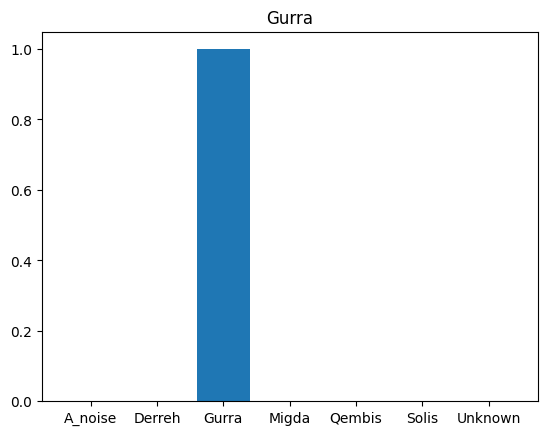

In [60]:
#Run Inference using imported model
#the truth audio and the predicted audio is displayed in bar and audio format
print('....Inference running using saved spec model........')
#features= run_inference(x, spec_model,spectrogram_used=True)

run_inference(x, spec_model, labels_list, spectrogram_used=True)


....Inference running using keras spec model........
.......The original Audio.............


.....Using Spectrogram Feature........
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


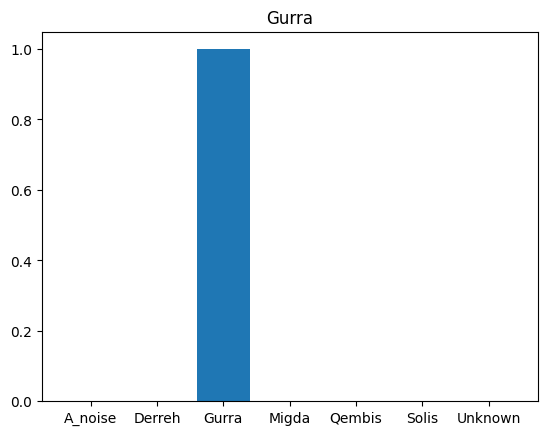

In [65]:

print('....Inference running using keras spec model........')
features= run_inference(x, imSpec_model, labels_list, spectrogram_used=True)

Perform inference using a TensorFlow Lite (TFLite) model on an audio file.

....Import model it used  Spectrogram Feature........
.......The original Audio.............


(1, 61, 257)
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


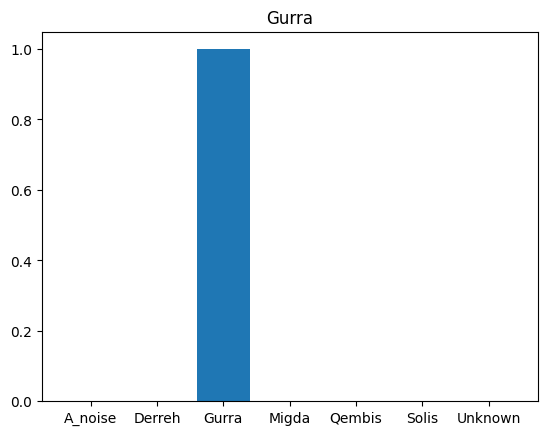

In [100]:
print('....Import model it used  Spectrogram Feature........')
model_path="../Model/simpleSpeech/specModel/QfRNN_specmodel_V602.tflite"
#Upload an audio data from the file and load labels of the predicted class
#x= '../_V_Data/Qf_For_test/Afar-afe_test1.wav'

run_inference_tflite(x, model_path , labels_list,spectrogram_used=True)

## Train and Evaluate the Model For MFCC feature

By using  `apply_CNN` function obtain the model (model_mfcc) and datasets (trainM__ds, valM_ds, testM_ds) required for training and evaluation. This function appears to handle the creation of a convolutional neural network (CNN) model and preprocessing of the datasets.

In [68]:
model_mfcc  =apply_RNN(inMfcc_shape, num_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 59, 128)           72704     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 131,335
Trainable params: 131,335
Non-trainable params: 0
_________________________________________________________________


The code snippet train a model (model_mfcc) using training and validation data (trainM_ds and valM_ds) for a certain number of epochs (EPOCHS). It also includes an EarlyStopping callback to monitor the validation loss and stop training if it doesn't improve after a certain number of epochs (patience=2 in this case).

In [69]:
EPOCHS = 10

history_mfcc = model_mfcc.fit(
        train_mfcc_ds,
        validation_data=val_mfcc_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

Epoch 1/10


49/49 [==============================] - 27s 371ms/step - loss: 1.4946 - accuracy: 0.4049 - val_loss: 1.0148 - val_accuracy: 0.6071
Epoch 2/10
49/49 [==============================] - 19s 385ms/step - loss: 0.6705 - accuracy: 0.7481 - val_loss: 0.4648 - val_accuracy: 0.8172
Epoch 3/10
49/49 [==============================] - 20s 397ms/step - loss: 0.3764 - accuracy: 0.8745 - val_loss: 0.2718 - val_accuracy: 0.8992
Epoch 4/10
49/49 [==============================] - 19s 393ms/step - loss: 0.1985 - accuracy: 0.9413 - val_loss: 0.2641 - val_accuracy: 0.9244
Epoch 5/10
49/49 [==============================] - 19s 393ms/step - loss: 0.1468 - accuracy: 0.9604 - val_loss: 0.1816 - val_accuracy: 0.9454
Epoch 6/10
49/49 [==============================] - 19s 390ms/step - loss: 0.1000 - accuracy: 0.9780 - val_loss: 0.1661 - val_accuracy: 0.9580
Epoch 7/10
49/49 [==============================] - 20s 408ms/step - loss: 0.1131 - accuracy: 0.9725 - val_loss: 0.1461 - val_accuracy: 0.9517
Epoch 8/10


To plot the training and validation loss curve using a function named `plot_training` by passing the history_mfcc object, likely the training history of the model model_mfcc.

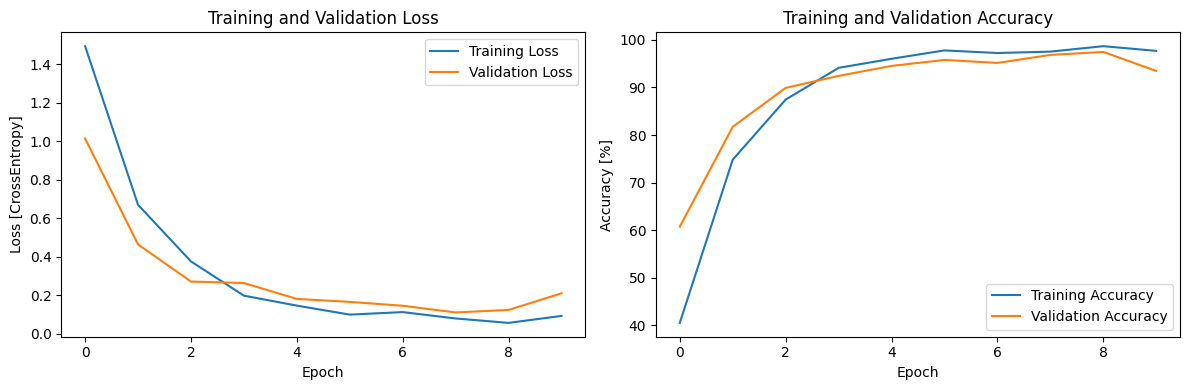

In [71]:
#Plot the training validation loss curve
plot_training(history_mfcc)

Evaluate the model's performance on the test dataset (tst_ft_ds) and visualize the confusion matrix using a function called `Eval_conf`. Additionally, defined label_names as a list of labels from the class of the data


.....Evaluate the model......
15/15 [==============================] - 2s 100ms/step - loss: 0.1379 - accuracy: 0.9611
Accuracy in (%):- 96.10678553581238
Loss:- 0.13786831498146057
.....Draw the confusion matrix of the model......
15/15 [==============================] - 2s 87ms/step


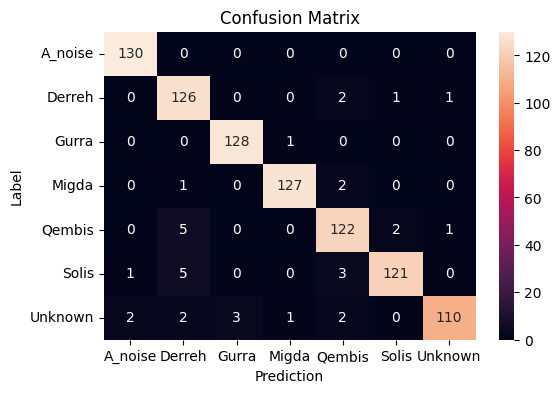

In [72]:
Eval_conf(test_mfcc_ds, model_mfcc, labels_list)

.......The original Audio.............


.....Using MFCC Feature........
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


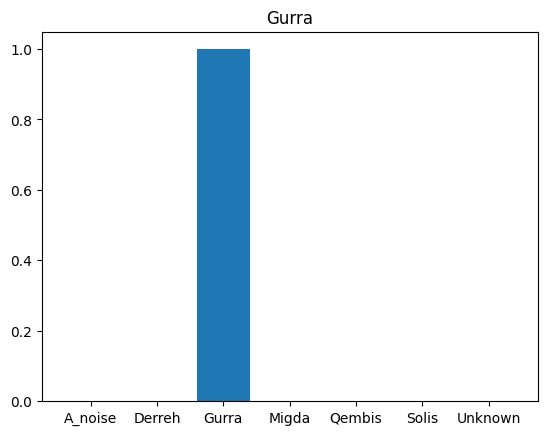

In [73]:
#Load an audio and convert to tensorflow
x= '../_V_Data/Qf_For_test/Afar-afe_test4.wav'

#the NAme of the model and feature of the audio data is parameter and
#the truth audio and the predicted audio is displayed in bar and audio format

run_inference(x, model_mfcc,labels_list, spectrogram_used=False)



In [ ]:
# Save model in H5 keras model format
ks_model_filename = '../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602.h5'
model_save(model_mfcc, ks_model_filename)

# Save the model in TensorFlow's 'saved_model' format
sv_model_filename = '../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602'
tf.saved_model.save(model_mfcc, sv_model_filename)


In [91]:

# Convert the keras model to tflite model
tflite_filename1 = "../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602.tflite"
model_save_tflite(model_mfcc, tflite_filename1)

INFO:tensorflow:Assets written to: C:\Users\Mu_keeS\AppData\Local\Temp\tmpkyztvbn2\assets


INFO:tensorflow:Assets written to: C:\Users\Mu_keeS\AppData\Local\Temp\tmpkyztvbn2\assets


In [75]:
#Import saved model
# to save "models.save_model" then use to load use "models.load_model" or
# to save use "tf.saved_model.save" then to load use tf.saved_model.load

sMfcc_model = tf.saved_model.load('../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602')
imMfcc_model =tf.saved_model.load('../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602.h5')


#sMfcc_model = models.load_model("../Model/simpleSpeech/mfccModel/Qf_mfccmodel_V600")
#imMfcc_model = models.load_model('../Model/simpleSpeech/mfccModel/Qf_mfccmodel_V600.h5')

....Inference running using saved mfcc model........
.......The original Audio.............


.....Using MFCC Feature........
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


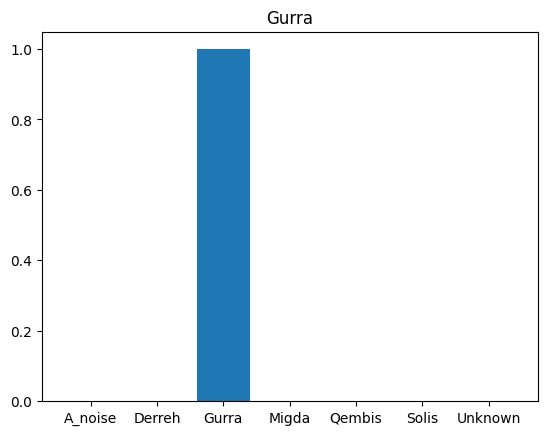

In [76]:
#Run Inference using imported model
#the truth audio and the predicted audio is displayed in bar and audio format
print('....Inference running using saved mfcc model........')

run_inference(x, sMfcc_model, labels_list, spectrogram_used=False)



....Inference running using keras mfcc model........
.......The original Audio.............


.....Using MFCC Feature........
Predicted label is:Gurra
Inference Time:2.2699940018355846e-05


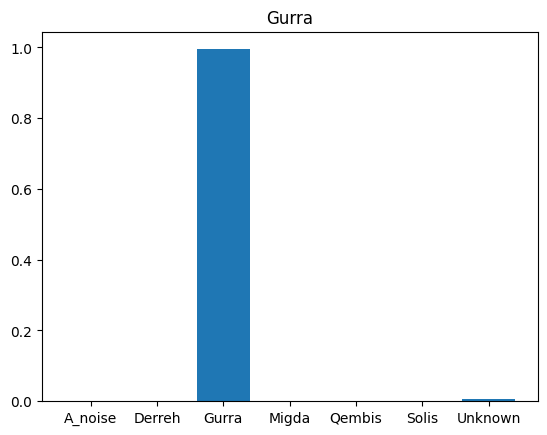

In [122]:

print('....Inference running using keras mfcc model........')
run_inference(x, imMfcc_model, labels_list, spectrogram_used=False)

....Import model it used  MFCC Feature........
.......The original Audio.............


(1, 59, 13)
Predicted label is:Gurra
Inference Time:1.6900012269616127e-05


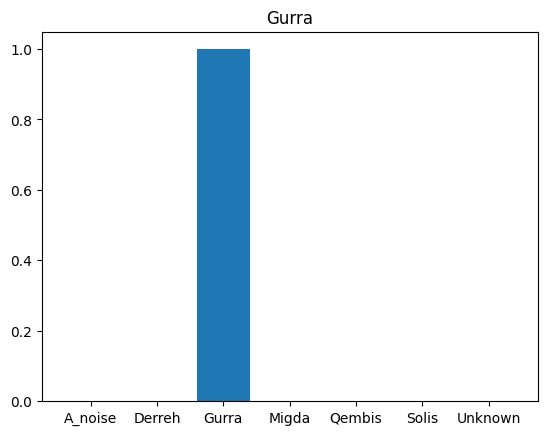

In [99]:
# run inference using tflite model
print('....Import model it used  MFCC Feature........')
model_path="../Model/simpleSpeech/mfccModel/QfRNN_mfccmodel_V602.tflite"
run_inference_tflite(x, model_path , labels_list,spectrogram_used=False)

## Next steps
Build and interactive mobile app or Embedded system to control the wheelchair